In [ ]:
import shutil
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import os
from os import listdir

import torch
import torch.nn as nn
import cv2 as cv
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
DATASET_PATH = r"D:\Praktikum_IPSD\Dataset\dinosaur"

# Verifikasi path
if os.path.exists(DATASET_PATH):
    print(f"Dataset ditemukan di: {DATASET_PATH}")
    print("Isi folder:", os.listdir(DATASET_PATH))
else:
    print("Path salah! Cek kembali lokasi foldermu.")

In [ ]:
# konfigurasi device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {device}")

In [ ]:
class getImageLabel(Dataset):
    def __init__(self, folder):
        self.dataset = []
        class_names = sorted([d for d in listdir(folder) if os.path.isdir(os.path.join(folder, d))])
        to_one_hot = np.eye(len(class_names)) 

        for i, dino in enumerate(class_names):
            class_path = os.path.join(folder, dino) 
            
            for image_name in listdir(class_path):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    full_path = os.path.join(class_path, image_name)
                    img = cv.imread(full_path)
                    
                    if img is not None:
                        img = cv.resize(img, (100, 100)) / 255.0
                        img = np.transpose(img, (2, 0, 1))
                        
                        self.dataset.append([img, to_one_hot[i]])

    def __getitem__(self, item):
        feature, label = self.dataset[item]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.dataset)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, input_dim=200, input_c=3, output=5, hidden_dim=128):
        super(SimpleCNN, self).__init__()

        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=input_c, out_channels=20, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3)),
        )

        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3)),
        )
        
        self.fc = nn.Linear(in_features=50 * 9 * 9, out_features=output)
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        # 1. Flatten
        x = x.view(x.size(0), -1) 
        # 2. Masukkan ke Fully Connected Layer (FC)
        x = self.fc(x)
        # 3. Activation terakhir
        x = self.Softmax(x)

        return x

epoch =  4 train loss =  0.20017588936856814 , test loss =  0.17379025369882584
epoch =  5 train loss =  0.142554907394307 , test loss =  0.13581745965140207
epoch =  6 train loss =  0.13358184535588538 , test loss =  0.11277359617607934
epoch =  7 train loss =  0.11710468466792788 , test loss =  0.09589868411421776
epoch =  8 train loss =  0.09122459590435028 , test loss =  0.08154314989224076
epoch =  9 train loss =  0.06202186963387898 , test loss =  0.08500589377113751
epoch =  10 train loss =  0.058245940400021415 , test loss =  0.07577156528298344


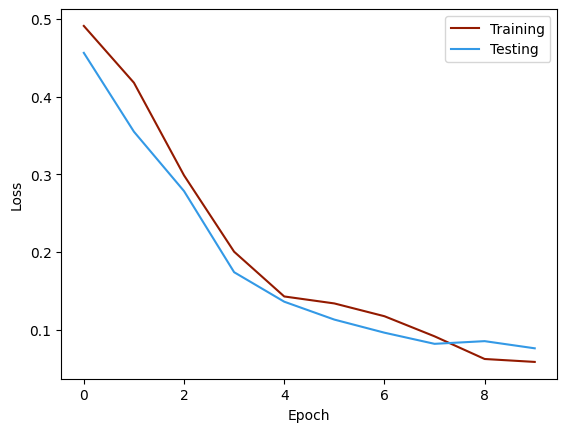

In [15]:
def train(path_folder):
    BATCH_SIZE = 32
    EPOCH = 10
    LEARNING_RATE = 0.001

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # === UBAHAN 1: PATH ===
    # Menggunakan path lokal dari parameter fungsi, bukan '/content/dataset'
    train_loader = DataLoader(getImageLabel(folder=path_folder), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(getImageLabel(folder=path_folder), batch_size=BATCH_SIZE, shuffle=False)

    model = SimpleCNN(input_dim=200, input_c=3, output=5, hidden_dim=128)
    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    
    # === UBAHAN 2: LOSS FUNCTION ===
    # Karena model kamu pakai Softmax di akhir & targetnya One-Hot Encoding, 
    # pasangan yang benar adalah BCELoss. Kalau pakai CrossEntropyLoss bakal error dimensi.
    loss_function = nn.BCELoss()

    loss_train_all, loss_test_all = [], []
    for epoch in range(EPOCH):
        train_loss = 0
        test_loss = 0
        model.train()
        for batch, (src, trg) in enumerate(train_loader):
            # === UBAHAN 3: PERMUTE ===
            # Aku hapus .permute() karena di Class Dataset (getImageLabel) kita sudah pakai 
            # np.transpose, jadi datanya sudah rapi (Channel, Height, Width).
            # Kalau di-permute lagi malah jadi rusak.
            
            src = src.to(device) 
            trg = trg.to(device)

            pred = model(src)
            loss = loss_function(pred, trg)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Bagian Testing
        model.eval()
        with torch.no_grad(): # Tambahan dikit biar RAM gak jebol
            for batch, (src, trg) in enumerate(test_loader):
                src = src.to(device)
                trg = trg.to(device)

                pred = model(src)
                loss = loss_function(pred, trg)
                test_loss += loss.item()

        loss_train_all.append(train_loss / len(train_loader))
        loss_test_all.append(test_loss / len(test_loader))
        
        print("epoch = ", epoch + 1, "train loss = ", train_loss / len(train_loader), ", test loss = ",
                test_loss / len(test_loader))

        if (epoch + 1) % 10 == 0:
            # Simpan file di folder lokal, bukan /content/
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss / len(train_loader),
            }, f"SimpleCNN_{epoch + 1}.pt")

    # Plotting (Disimpan di folder lokal)
    plt.figure()
    plt.plot(range(EPOCH), loss_train_all, color="#931a00", label='Training')
    plt.plot(range(EPOCH), loss_test_all, color="#3399e6", label='Testing')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("training.png")
    plt.show()

# === JALANKAN ===
# Masukkan path folder 'dinosaur' kamu di sini
train(DATASET_PATH)

Using device: cpu
[[32  0  0  0  8]
 [ 0 39  0  0  1]
 [ 0  0 40  0  0]
 [ 0  0  1 31  8]
 [ 0  0  0  0 40]]
accuracy score = 0.91
precision score = 0.9354728284124947
recall score = 0.91
f1 score = 0.9123733373378795


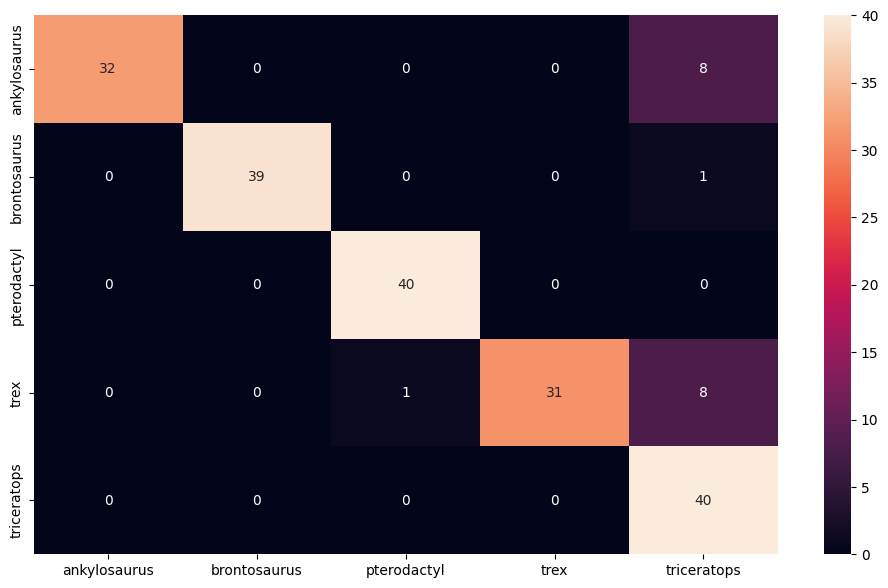

In [16]:
def test(dataset_path):
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # === UBAHAN 1: Path Dataset ===
    # Gunakan path lokal, bukan '/content/dataset/'
    test_loader = DataLoader(getImageLabel(folder=dataset_path),
                                batch_size=BATCH_SIZE, shuffle=True)

    model = SimpleCNN(input_dim=200, input_c=3, output=5, hidden_dim=128)
    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    # Load Model (Pastikan file SimpleCNN_10.pt ada di folder yang sama dengan file .ipynb kamu)
    # Jika kamu save dengan nama beda, sesuaikan string di bawah ini
    checkpoint = torch.load("SimpleCNN_10.pt", map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    prediction, ground_truth = [], []

    with torch.no_grad():
        model.eval()
        for batch, (src, trg) in enumerate(test_loader):
            # === UBAHAN 2: Hapus Permute ===
            # Data dari getImageLabel class sudah (Channel, H, W)
            # src = src.permute(0, 3, 1, 2)  <-- INI DIHAPUS
            
            src = src.to(device)
            trg = trg.to(device)

            pred = model(src)
            prediction.extend(torch.argmax(pred, dim=1).cpu().numpy())
            ground_truth.extend(torch.argmax(trg, dim=1).cpu().numpy())

    classes = ('ankylosaurus', 'brontosaurus', 'pterodactyl', 'trex', 'triceratops')

    cf_matrix = confusion_matrix(ground_truth, prediction)
    print(cf_matrix)

    df_cm = pd.DataFrame(cf_matrix,
                        index=[i for i in classes],
                        columns=[i for i in classes])

    plt.figure(figsize=(12, 7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    plt.savefig("confusion_matrix.png") # Akan tersimpan di folder project VS Code kamu

    print("accuracy score =", accuracy_score(ground_truth, prediction))
    print("precision score =", precision_score(ground_truth, prediction, average='weighted'))
    print("recall score =", recall_score(ground_truth, prediction, average='weighted'))
    print("f1 score =", f1_score(ground_truth, prediction, average='weighted'))

# === CARA JALANKAN ===
test(DATASET_PATH)